In [2]:
# coding=utf-8
from __future__ import absolute_import, division, print_function

import logging
import argparse
import os
import time
import datetime
import random
import numpy as np

from datetime import timedelta

import torch
import torch.distributed as dist

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
try:
    from apex import amp
    from apex.parallel import DistributedDataParallel as DDP
    has_apex = True
except ImportError:
    has_apex = False
    # raise ImportError("Please install apex from https://www.github.com/nvidia/apex to run this example.")

from models.modeling import VisionTransformer, CONFIGS
from utils.scheduler import WarmupLinearSchedule, WarmupCosineSchedule
from utils.data_utils import get_loader
from utils.dist_util import *
from timm.utils import accuracy, AverageMeter
from matplotlib import pyplot as plt
import cca_core

os.environ['CUDA_VISIBLE_DEVICES'] = "1"
def _plot_helper(arr, label=None, xlabel=None, ylabel=None):
    # plt.plot(arr, lw=2.0, label=label)
    if label is not None:
        plt.plot(arr, lw=2.0, label=label)
        plt.legend(loc="best")
    else:
        plt.plot(arr, lw=2.0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.legend(loc="best")
    plt.grid()

In [3]:
# Setup CUDA, GPU & distributed training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)


# Model & Tokenizer Setup
config = CONFIGS["ViT-B_16"]
num_classes = 100
model = VisionTransformer(config, 224, zero_head=True, num_classes=num_classes)
# loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=3e-2,
                            momentum=0.9,
                            weight_decay=0)

PATH = "./logs/cifar100/cifar100-b16/cifar100-b16-Best.pth"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
max_accuracy = checkpoint['max_accuracy']
print("Load model from %s, epoch %d, max_accuracy %f" % (PATH, epoch, max_accuracy))

Load model from ./logs/cifar100/cifar100-b16/cifar100-b16-Best.pth, epoch 7, max_accuracy 92.460000


针对head_num=12,layer=0的query的投影W[768,768]拆分为针对12个head的维度为[768,64]的投影W

In [7]:
special_layers = ["encoder.layer.0.attn"]
queryWeight = []
for name, param in model.named_parameters():
    # print(name, param.shape, type(param))
    if 'query.weight' in name:
        print(name, param.shape, type(param))
        queryWeight.append(param)


# 沿着第二个维度将张量分割为12个大小为[768, 64]的张量
split_tensors = [torch.chunk(queryWeight[i], 12, dim=1) for i in range(len(queryWeight))]
w = np.zeros((12, 12, 64, 768))  # w[i, j]表示第i个layer的第j个head的权重
for i in range(len(queryWeight)):
    tmp_tensor = split_tensors[i]
    for j in range(12):
        w[i, j] = tmp_tensor[j].detach().cpu().numpy().T

'''
checkpoint = torch.load("%s" % args.load)['model']
model_dict = model.state_dict()
state_dict = {k.replace('module.', ''):v for k,v in checkpoint.items() if k in model_dict.keys()}  # load same name layer weiget
model_dict.update(state_dict)
model.load_state_dict(model_dict, strict=False)  # 载入我自己训练的vqa_large_base模型权重
# 冻结后半部分权重  for exchange2
unfreeze_layers = ['x_layers.5', 'x_layers.6', 'x_layers.7', 'x_layers.8', 'x_layers.9', 'x_layers.10', 'bert.pooler', 'logit_fc']
for name, param in model.named_parameters():
    param.requires_grad = False
    for ele in unfreeze_layers:
        if ele in name:
            param.requires_grad = True
            break
model.eval()
'''

transformer.encoder.layer.0.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.1.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.2.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.3.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.4.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.5.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.6.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.7.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.8.attn.query.weight torch.Size([768, 768]) <class 'torch.nn.parameter.Parameter'>
transformer.encoder.layer.9.

'\ncheckpoint = torch.load("%s" % args.load)[\'model\']\nmodel_dict = model.state_dict()\nstate_dict = {k.replace(\'module.\', \'\'):v for k,v in checkpoint.items() if k in model_dict.keys()}  # load same name layer weiget\nmodel_dict.update(state_dict)\nmodel.load_state_dict(model_dict, strict=False)  # 载入我自己训练的vqa_large_base模型权重\n# 冻结后半部分权重  for exchange2\nunfreeze_layers = [\'x_layers.5\', \'x_layers.6\', \'x_layers.7\', \'x_layers.8\', \'x_layers.9\', \'x_layers.10\', \'bert.pooler\', \'logit_fc\']\nfor name, param in model.named_parameters():\n    param.requires_grad = False\n    for ele in unfreeze_layers:\n        if ele in name:\n            param.requires_grad = True\n            break\nmodel.eval()\n'

对每一层的head0,1计算平均相似度，发现随着层数的加深，相似度在明显减少。

说明层数越深，多头拆分出的feature层次越高，越抽象，多头之间越diversify

W[0, 0] and W[0, 1] Mean all_CCA similarity 0.667534
W[1, 0] and W[1, 1] Mean all_CCA similarity 0.556451
W[2, 0] and W[2, 1] Mean all_CCA similarity 0.466020
W[3, 0] and W[3, 1] Mean all_CCA similarity 0.401103
W[4, 0] and W[4, 1] Mean all_CCA similarity 0.384852
W[5, 0] and W[5, 1] Mean all_CCA similarity 0.383219
W[6, 0] and W[6, 1] Mean all_CCA similarity 0.360973
W[7, 0] and W[7, 1] Mean all_CCA similarity 0.343100
W[8, 0] and W[8, 1] Mean all_CCA similarity 0.341342
W[9, 0] and W[9, 1] Mean all_CCA similarity 0.311925
W[10, 0] and W[10, 1] Mean all_CCA similarity 0.284864
W[11, 0] and W[11, 1] Mean all_CCA similarity 0.274241


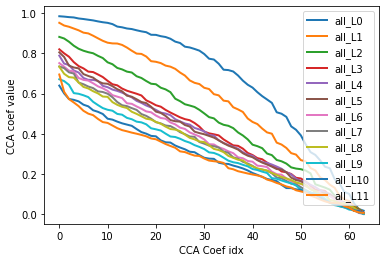

In [32]:
def all_cca(layer1, head1, layer2, head2, draw=True, isprint=True):
    acts1, acts2 = w[layer1, head1], w[layer2, head2]
    # print("activation shapes", acts1.shape, acts2.shape)
    results = cca_core.get_cca_similarity(acts1, acts2, epsilon=1e-10, verbose=False)
    if draw:
        _plot_helper(results["cca_coef1"], "all_L%d" % (layer1), "CCA Coef idx", "CCA coef value")
    if isprint:
        print("W[%d, %d] and W[%d, %d] Mean all_CCA similarity %f" % (layer1, head1, layer2, head2, np.mean(results["cca_coef1"])))
    return np.mean(results["cca_coef1"])

for i in range(12):
    all_cca(i, 0, i, 1)

对layer0的head0的权重矩阵W(维度是[768, 64])PCA降维后，进行可视化

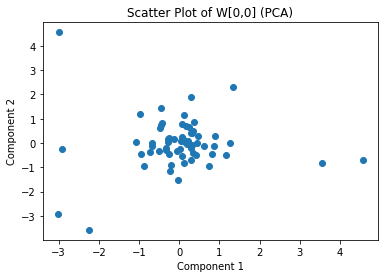

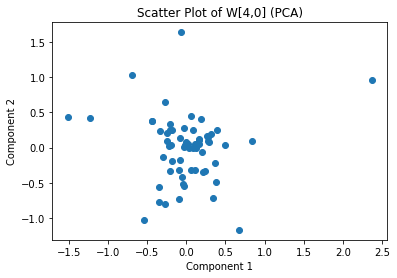

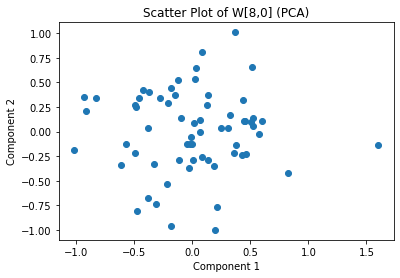

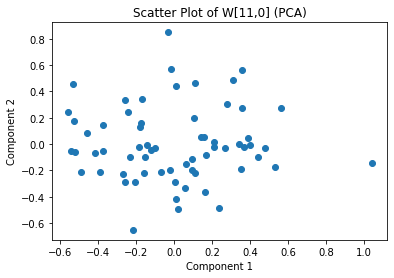

In [33]:
from sklearn.decomposition import PCA
def PCA_visualization(layer, head, draw=True):
    pca = PCA(n_components=2)
    matrix_reduced = pca.fit_transform(w[layer, head])
    if draw:
        plt.scatter(matrix_reduced[:, 0], matrix_reduced[:, 1])
        plt.title('Scatter Plot of W[%d,%d] (PCA)' % (layer, head))
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.show()

for i in range(12):
    PCA_visualization(i, 0, draw=False if (i % 4 and i != 11) else True)

做SVD分解，确定从64维中提取前30维，可以使每层保留50%+的激活方差信息

W[0, 0] Fraction of variance explained by 30 singular vectors 0.696837
W[1, 0] Fraction of variance explained by 30 singular vectors 0.644804
W[2, 0] Fraction of variance explained by 30 singular vectors 0.601677
W[3, 0] Fraction of variance explained by 30 singular vectors 0.584918
W[4, 0] Fraction of variance explained by 30 singular vectors 0.579633
W[5, 0] Fraction of variance explained by 30 singular vectors 0.576179
W[6, 0] Fraction of variance explained by 30 singular vectors 0.571514
W[7, 0] Fraction of variance explained by 30 singular vectors 0.568643
W[8, 0] Fraction of variance explained by 30 singular vectors 0.565582
W[9, 0] Fraction of variance explained by 30 singular vectors 0.554065
W[10, 0] Fraction of variance explained by 30 singular vectors 0.542485
W[11, 0] Fraction of variance explained by 30 singular vectors 0.539823


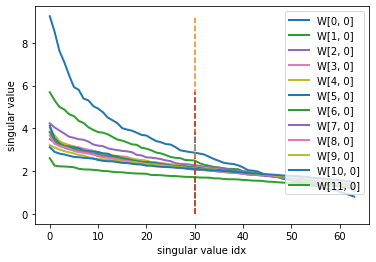

In [34]:
def extract_topk(layer, head, k=30, draw=True):
    _, s, v = np.linalg.svd(w[layer, head] - np.mean(w[layer, head], axis=1, keepdims=True), full_matrices=False)
    if draw:
        _plot_helper(s, "W[%d, %d]" % (layer, head), "singular value idx", "singular value")
        plt.plot([k]*10, np.linspace(0, s[0], 10), linestyle="--")
    print("W[%d, %d] Fraction of variance explained by %d singular vectors %f" % (layer, head, k, np.sum(s[:k])/np.sum(s)))

for i in range(12):
    extract_topk(i, 0, 30)

SVCCA提取前30维后发现，对每层的head0,head1之间的相似程度，几乎没有区别



Results using SVCCA keeping 30 dims
W[0, 0] and W[0, 1] Mean SVCCA similarity 0.609377
W[1, 0] and W[1, 1] Mean SVCCA similarity 0.506451
W[2, 0] and W[2, 1] Mean SVCCA similarity 0.421554
W[3, 0] and W[3, 1] Mean SVCCA similarity 0.354526
W[4, 0] and W[4, 1] Mean SVCCA similarity 0.337305
W[5, 0] and W[5, 1] Mean SVCCA similarity 0.346257
W[6, 0] and W[6, 1] Mean SVCCA similarity 0.343198
W[7, 0] and W[7, 1] Mean SVCCA similarity 0.327644
W[8, 0] and W[8, 1] Mean SVCCA similarity 0.319250
W[9, 0] and W[9, 1] Mean SVCCA similarity 0.269205
W[10, 0] and W[10, 1] Mean SVCCA similarity 0.225114
W[11, 0] and W[11, 1] Mean SVCCA similarity 0.209392


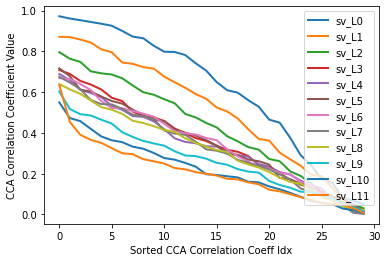

In [35]:
def svcca(layer1, head1, layer2, head2, k=20, draw=True, isprint=True):
    # Mean subtract activations
    cacts1 = w[layer1, head1] - np.mean(w[layer1, head1], axis=1, keepdims=True)
    cacts2 = w[layer2, head2] - np.mean(w[layer2, head2], axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

    svacts1 = np.dot(s1[:k]*np.eye(k), V1[:k])
    # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
    svacts2 = np.dot(s2[:k]*np.eye(k), V2[:k])
    # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

    svcca_results = cca_core.get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)
    if isprint:
        print("W[%d, %d] and W[%d, %d] Mean SVCCA similarity %f" % (layer1, head1, layer2, head2, np.mean(svcca_results["cca_coef1"])))
    if draw:
        _plot_helper(svcca_results["cca_coef1"], "sv_L%d" % (layer1), "Sorted CCA Correlation Coeff Idx", "CCA Correlation Coefficient Value")
    return np.mean(svcca_results["cca_coef1"])


k = 30
print("Results using SVCCA keeping %d dims" % (k))
for i in range(12):
    svcca(i, 0, i, 1, k=k)

W[0, 0] and W[0, 1] Mean all_CCA similarity 0.667534
W[0, 0] and W[0, 1] Mean SVCCA similarity 0.576176


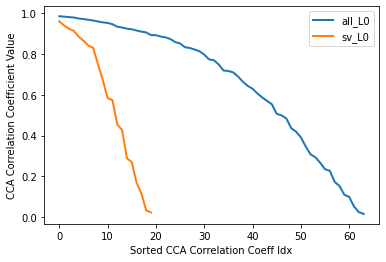

W[4, 0] and W[4, 1] Mean all_CCA similarity 0.384852
W[4, 0] and W[4, 1] Mean SVCCA similarity 0.300923


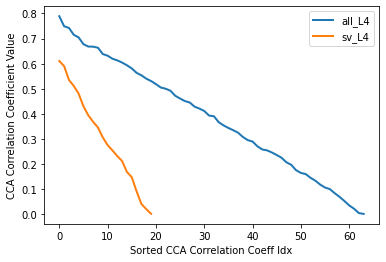

W[8, 0] and W[8, 1] Mean all_CCA similarity 0.341342
W[8, 0] and W[8, 1] Mean SVCCA similarity 0.307911


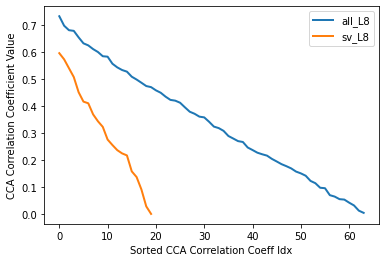

W[11, 0] and W[11, 1] Mean all_CCA similarity 0.274241
W[11, 0] and W[11, 1] Mean SVCCA similarity 0.177798


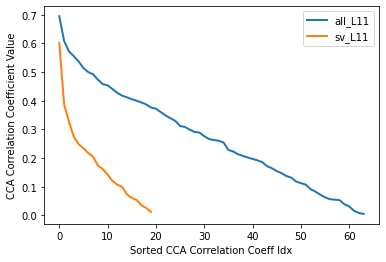

In [36]:
for i in range(12):
    if i % 4 and i != 11:
        continue
    all_cca(i, 0, i, 1)
    svcca(i, 0, i, 1, k=20)
    plt.show()

针对某些层的12个head对应的投影W互相之间的相似度进行可视化

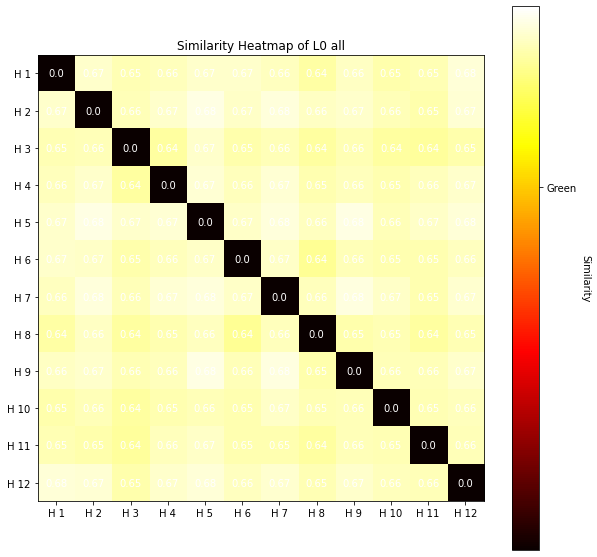

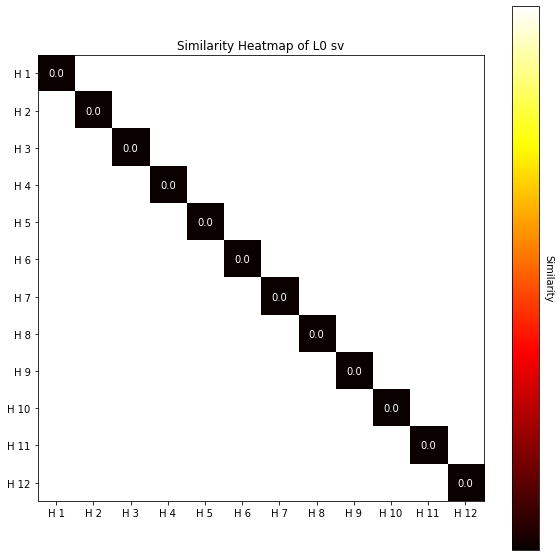

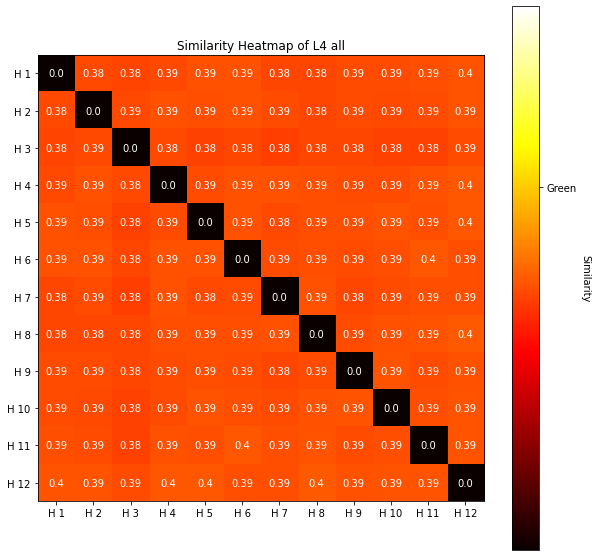

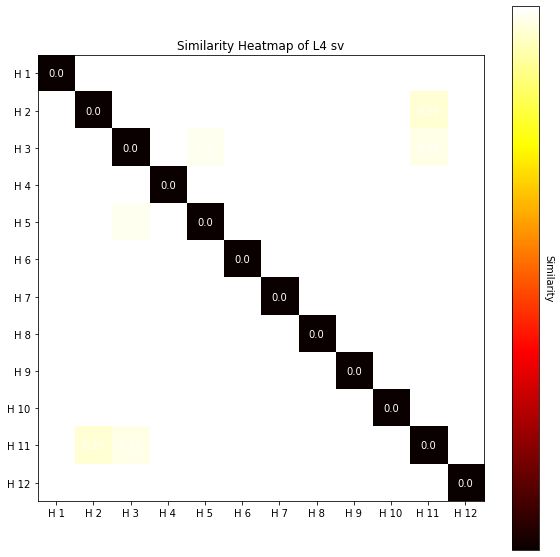

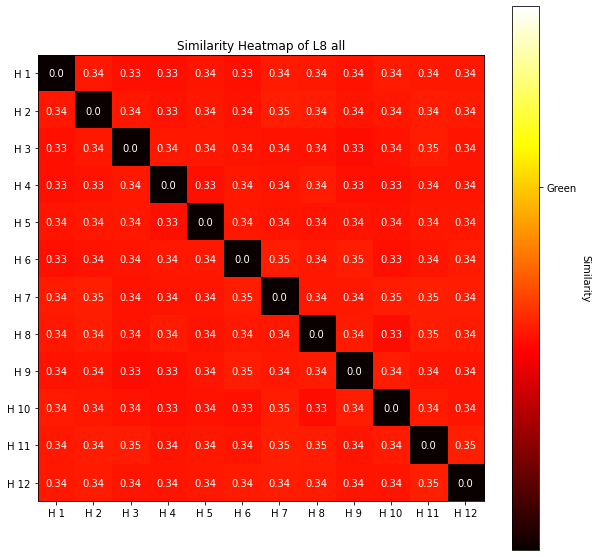

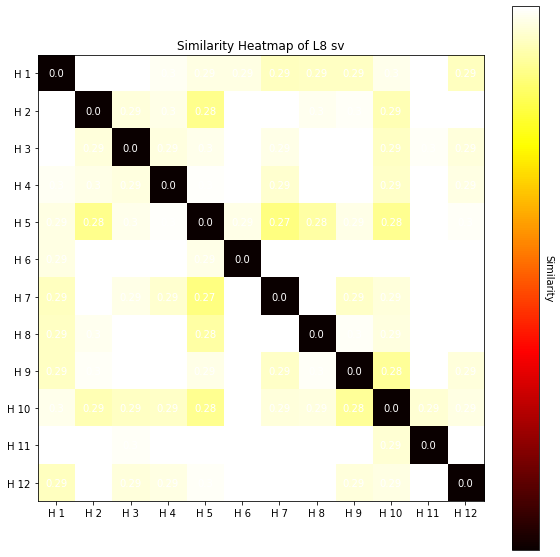

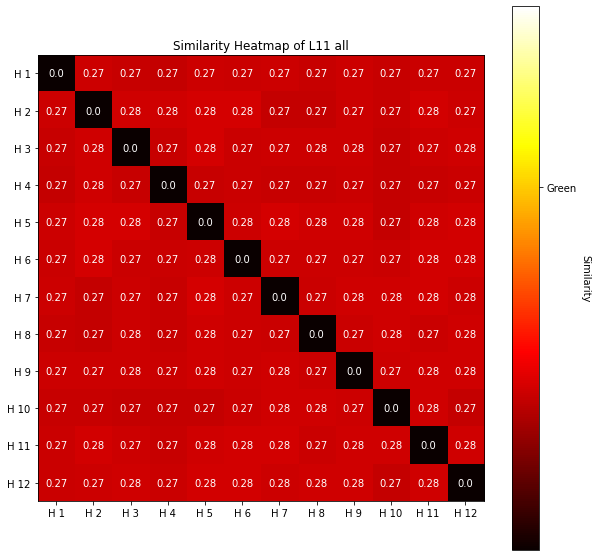

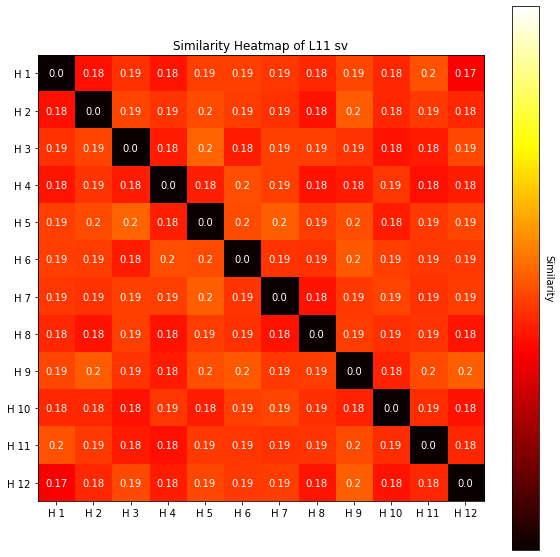

In [49]:
def hotmap(layer, draw=True, type="all", Vmin=0, Vmax=1):
    head_num = 12

    sims = np.zeros((head_num, head_num))
    # 计算两两之间的相似度
    for i in range(head_num):
        for j in range(i+1, head_num):
            if type == "all":
                sims[i, j] = all_cca(layer, i, layer, j, draw=False, isprint=False)
            elif type == "sv":
                sims[i, j] = svcca(layer, i, layer, j, k=20, draw=False, isprint=False)
            sims[j, i] = sims[i, j]

    # 画出热力图
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(sims, cmap='hot')

    # 添加坐标轴标签和标题
    ax.set_xticks(np.arange(head_num))
    ax.set_yticks(np.arange(head_num))
    ax.set_xticklabels(['H {}'.format(i+1) for i in range(head_num)])
    ax.set_yticklabels(['H {}'.format(i+1) for i in range(head_num)])
    # ax.set_xlabel('Variable')
    # ax.set_ylabel('Variable')
    ax.set_title('Similarity Heatmap of L%d ' % (layer) + type)

    # 添加数值到热力图中
    for i in range(head_num):
        for j in range(head_num):
            text = ax.text(j, i, round(sims[i, j], 2), ha='center', va='center', color='w')

    # 添加colorbar
    im.set_clim(Vmin, Vmax)
    cbar = ax.figure.colorbar(im, ax=ax)
    # cbar.set_ticks([0, 0.5, 1])
    # cbar.set_ticklabels(['Yellow', 'Green', 'Blue'])
    cbar.ax.set_ylabel('Similarity', rotation=-90, va='bottom')

    # 展示图像
    plt.show()

# hotmap(layer=0, type="all", Vmin=0.5, Vmax=0.7)
# hotmap(layer=0, type="sv", Vmin=0.5, Vmax=0.7)

# hotmap(layer=4, type="all", Vmin=0.2, Vmax=0.4)
# hotmap(layer=4, type="sv", Vmin=0.2, Vmax=0.4)

# hotmap(layer=8, type="all", Vmin=0.2, Vmax=0.4)
# hotmap(layer=8, type="sv", Vmin=0.2, Vmax=0.4)

# hotmap(layer=11, type="all", Vmin=0.1, Vmax=0.3)
# hotmap(layer=11, type="sv", Vmin=0.1, Vmax=0.3)
for i in range(12):
    if i % 4 and i != 11:
        continue
    hotmap(i, type="all", Vmin=0.1, Vmax=0.7)
    hotmap(i, type="sv", Vmin=0.1, Vmax=0.3)
